In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZATION_WD import _dataset, VAE, study, compare_continuous, compare_integer#, compare_distributions_binned_aux, compare_distributions_binned

# For saving img
from os.path import join, basename, exists
from os import getcwd
dir_name = basename(getcwd())
img_dir = join(getcwd(), "images")
if not exists(img_dir):
    os.mkdir(img_dir)
variante= 'WD'
dir_name

[I 2021-09-05 14:29:19,785] Using an existing study with name 'Optimizing the VAE with WD - BKG vs Random Sampling' instead of creating a new one.


'non_zeros'

In [2]:
# For saving ROC Values
currect_dir = getcwd()
os.chdir("..")
base_directory = getcwd()
os.chdir(currect_dir) 

import pickle

try:
    rocs_scores = pickle.load( open( join(base_directory, "generate_tables", dir_name+"_"+variante+".p"), "rb" ) )
except:
    rocs_scores = {}

pickle.dump( rocs_scores, open( join(base_directory, "generate_tables", dir_name+"_"+variante+".p"), "wb" ) )

## Loading the Study

In [3]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 100
Best trial:
  Value: 6.630528688507764
  Params: 
    alpha: 6561
    hidden_size: 28
    lr: 0.00043266173297886026
    n_layers_decoder: 12
    n_layers_encoder: 4
    n_units_decoder_l0: 265
    n_units_decoder_l1: 475
    n_units_decoder_l10: 285
    n_units_decoder_l11: 85
    n_units_decoder_l2: 325
    n_units_decoder_l3: 385
    n_units_decoder_l4: 215
    n_units_decoder_l5: 265
    n_units_decoder_l6: 445
    n_units_decoder_l7: 75
    n_units_decoder_l8: 405
    n_units_decoder_l9: 445
    n_units_encoder_l0: 190
    n_units_encoder_l1: 20
    n_units_encoder_l2: 480
    n_units_encoder_l3: 20
 TRIAL NUMBER: 83


### Optuna Graphs

In [4]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image(join(img_dir, dir_name+variante+"_optuna_hp_importance.png"))
fig.show()

In [5]:
fig = optuna.visualization.plot_optimization_history(study)
fig.write_image(join(img_dir, dir_name+variante+"_optuna_optm_history.png"))
fig.show()

## Anomaly Detection

### Load the model

In [6]:
# Nao é o 49, 53, 33, 26, 25, 23, 22, 16
#name = "wd-sample_vs_data_trial_16"
#name = "wd-sample_vs_data_trial_{}".format(trial.number)
name = f"CustomTrain_WD-Data_vs_Sampling_trial_{trial.number}"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[16], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=47, out_features=190, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=190, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=20, out_features=480, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=480, out_features=20, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=20, out_features=28, bias=True)
  )
  (hidden2mu): Linear(in_features=28, out_features=28, bias=True)
  (hidden2log_var): Linear(in_features=28, out_features=28, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=28, out_features=265, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=265, out_features=475, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=475, out_features=325, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=325, ou

### Load data

In [7]:
# Bkg
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(334163, 47)

## Check if z ~ N(0,1)

In [8]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(334163, 28)

<ipython-input-9-9516a5a32fb3>:12: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



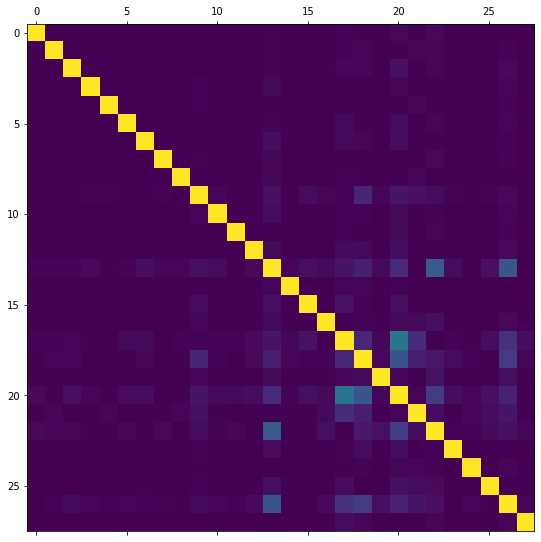

In [9]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

#axes = fig.add_subplot(1,2,i+1)
#i += 1
#axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.savefig(join(img_dir, dir_name+variante+"_correlation.png"), bbox_inches = 'tight')
fig.show()

In [10]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.38775
Mean:	 0.01367


Mean: 0.0006034278 	Std: 0.8539382
Mean: -0.007124707 	Std: 0.83464277
Mean: 0.0076281433 	Std: 0.8328882
Mean: 0.0047203917 	Std: 0.849888
Mean: -0.010420198 	Std: 0.84527403
Mean: -0.002941338 	Std: 0.82857853
Mean: 0.0007930374 	Std: 0.85136276
Mean: 0.021506019 	Std: 0.8339591
Mean: -0.011508593 	Std: 0.84249115
Mean: -0.076724656 	Std: 0.98249763
Mean: -0.015809769 	Std: 0.8450202
Mean: -0.0001189373 	Std: 0.8481979
Mean: 0.009098212 	Std: 0.81950414
Mean: 0.2334828 	Std: 1.2921699
Mean: 0.020012606 	Std: 0.841037
Mean: 0.0069123562 	Std: 0.8400666
Mean: 0.008246161 	Std: 0.83175766
Mean: -0.05707675 	Std: 0.9829891
Mean: 0.19497775 	Std: 0.978102
Mean: -0.015981542 	Std: 0.8240675
Mean: 0.21762356 	Std: 1.3039559
Mean: 0.007584996 	Std: 0.97825664
Mean: -0.47082528 	Std: 1.522701
Mean: 0.009719128 	Std: 0.8356776
Mean: -0.0049301386 	Std: 0.83016926
Mean: -0.0051891333 	Std: 0.82047534
Mean: -0.24344231 	Std: 1.4245733
Mean: -0.00043834053 	Std: 0.85002834


Total average mean -0

<ipython-input-11-1d03cc6f2ab4>:21: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



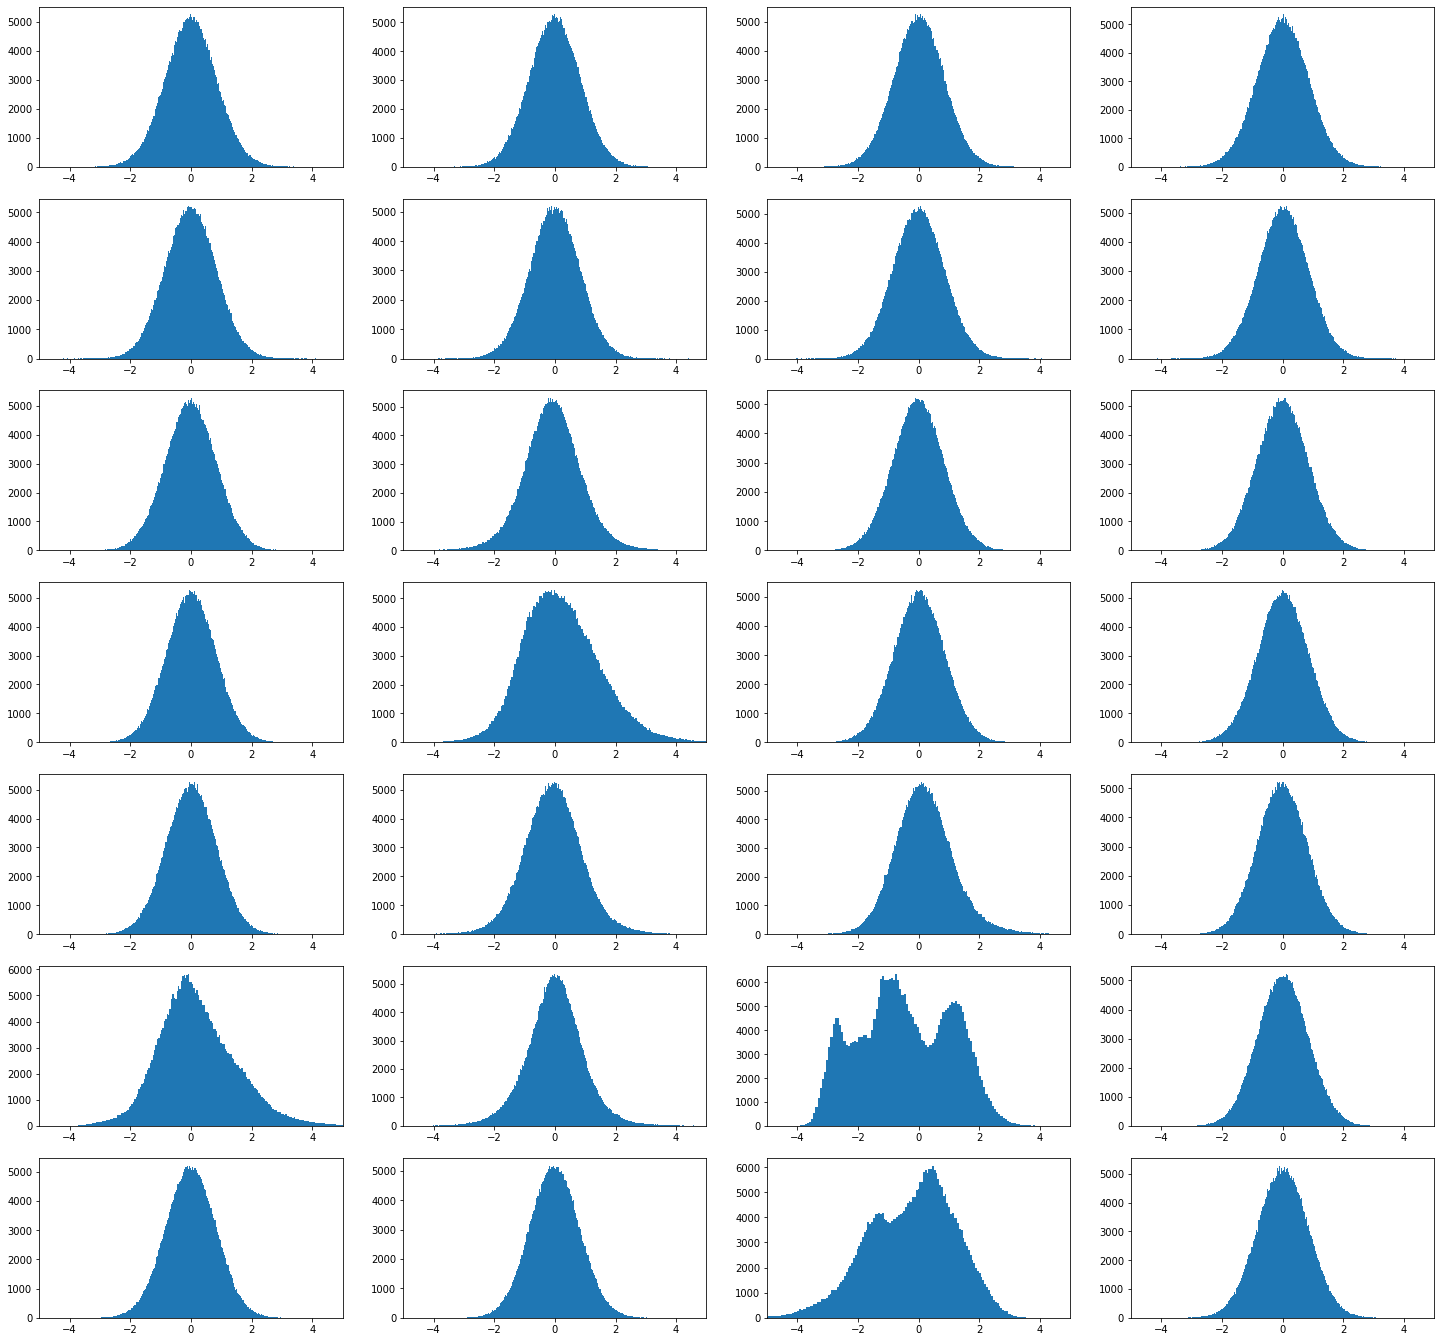

In [11]:

fig = plt.figure(figsize=[25,70])
i = 0

total_mean = []
total_std = []
for x in range(hidden.shape[1]):
    axes = fig.add_subplot(20,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    total_mean.append(hidden[:, x].mean())
    total_std.append(hidden[:, x].std())
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())

print("\n")
print("Total average mean", np.array(total_mean).mean())
print("Total average std", np.array(total_std).mean())
fig.savefig(join(img_dir, dir_name+variante+"_zdim_Dist.png"), bbox_inches = 'tight')
fig.show()

## Bkg Data vs Random Sampling Decoding

In [12]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

Electron_Multi    FatJet1_Eta   FatJet1_Mass     FatJet1_PT  \
count   334163.000000  334163.000000  334163.000000  334163.000000   
mean        -0.429549      -0.951221       0.577762      -0.367042   
std          0.569019       1.439926       0.518968       0.364839   
min         -0.916905      -3.360899      -1.323654      -1.049935   
25%         -0.859568      -2.170585       0.487393      -0.619609   
50%         -0.841977      -1.675006       0.661622      -0.475829   
75%          0.227256       0.467355       0.860989      -0.226495   
max          1.308465       2.781672       2.179601       1.832245   

         FatJet1_Phi   FatJet1_Tau1   FatJet1_Tau2   FatJet1_Tau3  \
count  334163.000000  334163.000000  334163.000000  334163.000000   
mean       -0.131166       0.672654      -0.176718      -0.226583   
std         0.938904       0.548004       0.353205       0.387859   
min        -3.707158      -1.117984      -0.932346      -1.045621   
25%        -0.864227       0.576358      -0.423988      -0.500566   
50%        -0.277553       0.811275      -0.163646      -0.221591   
75%         0.822379       1.004418       0.076923       0.046505   
max         1.727624       2.059629       2.336340       1.288135   

        FatJet1_Tau4   FatJet1_Tau5  ...    Lepton1_Eta     Lepton1_PT  \
count  334163.000000  334163.000000  ...  334163.000000  334163.000000   
mean       -0.240699      -0.247457  ...      -1.047582      -0.189190   
std         0.397361       0.396125  ...       1.293096       0.368810   
min        -1.067688      -1.064840  ...      -3.278228      -1.109725   
25%        -0.524333      -0.533355  ...      -2.111679      -0.452655   
50%        -0.239492      -0.251009  ...      -1.708540      -0.222040   
75%         0.036114       0.027387  ...       0.244310       0.013408   
max         1.351445       1.367637  ...       1.976751       2.239453   

         Lepton1_Phi    Lepton2_Eta     Lepton2_PT    Lepton2_Phi  \
count  334163.000000  334163.000000  334163.000000  334163.000000   
mean       -0.897165      -1.014583       0.156481       0.134891   
std         0.329830       1.226829       0.503681       0.807140   
min        -2.222272      -3.269714      -1.398424      -2.104621   
25%        -1.097374      -2.026861      -0.234247      -0.361398   
50%        -0.862848      -1.622988       0.075015       0.094658   
75%        -0.704056       0.217892       0.460122       0.792741   
max         1.102800       1.898560       2.945002       1.939964   

       MissingET_MET  MissingET_Phi     Muon_Multi    ScalarHT_HT  
count  334163.000000  334163.000000  334163.000000  334163.000000  
mean        0.143522      -0.386748       0.414841      -0.249342  
std         0.497955       0.621879       0.567600       0.386633  
min        -0.815719      -3.084857      -1.327275      -1.010643  
25%        -0.206661      -0.800916      -0.238819      -0.523698  
50%         0.031453      -0.394662       0.825360      -0.358473  
75%         0.389186       0.021593       0.843771      -0.081800  
max         4.073674       2.035228       0.905366       1.734516  

[8 rows x 47 columns]

In [13]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

    fig.tight_layout()
    fig.savefig(join(img_dir, dir_name+variante+f"_{second_name}_vs_bkg.png"), bbox_inches = 'tight')
    fig.show()

<ipython-input-13-fd11cf38c044>:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



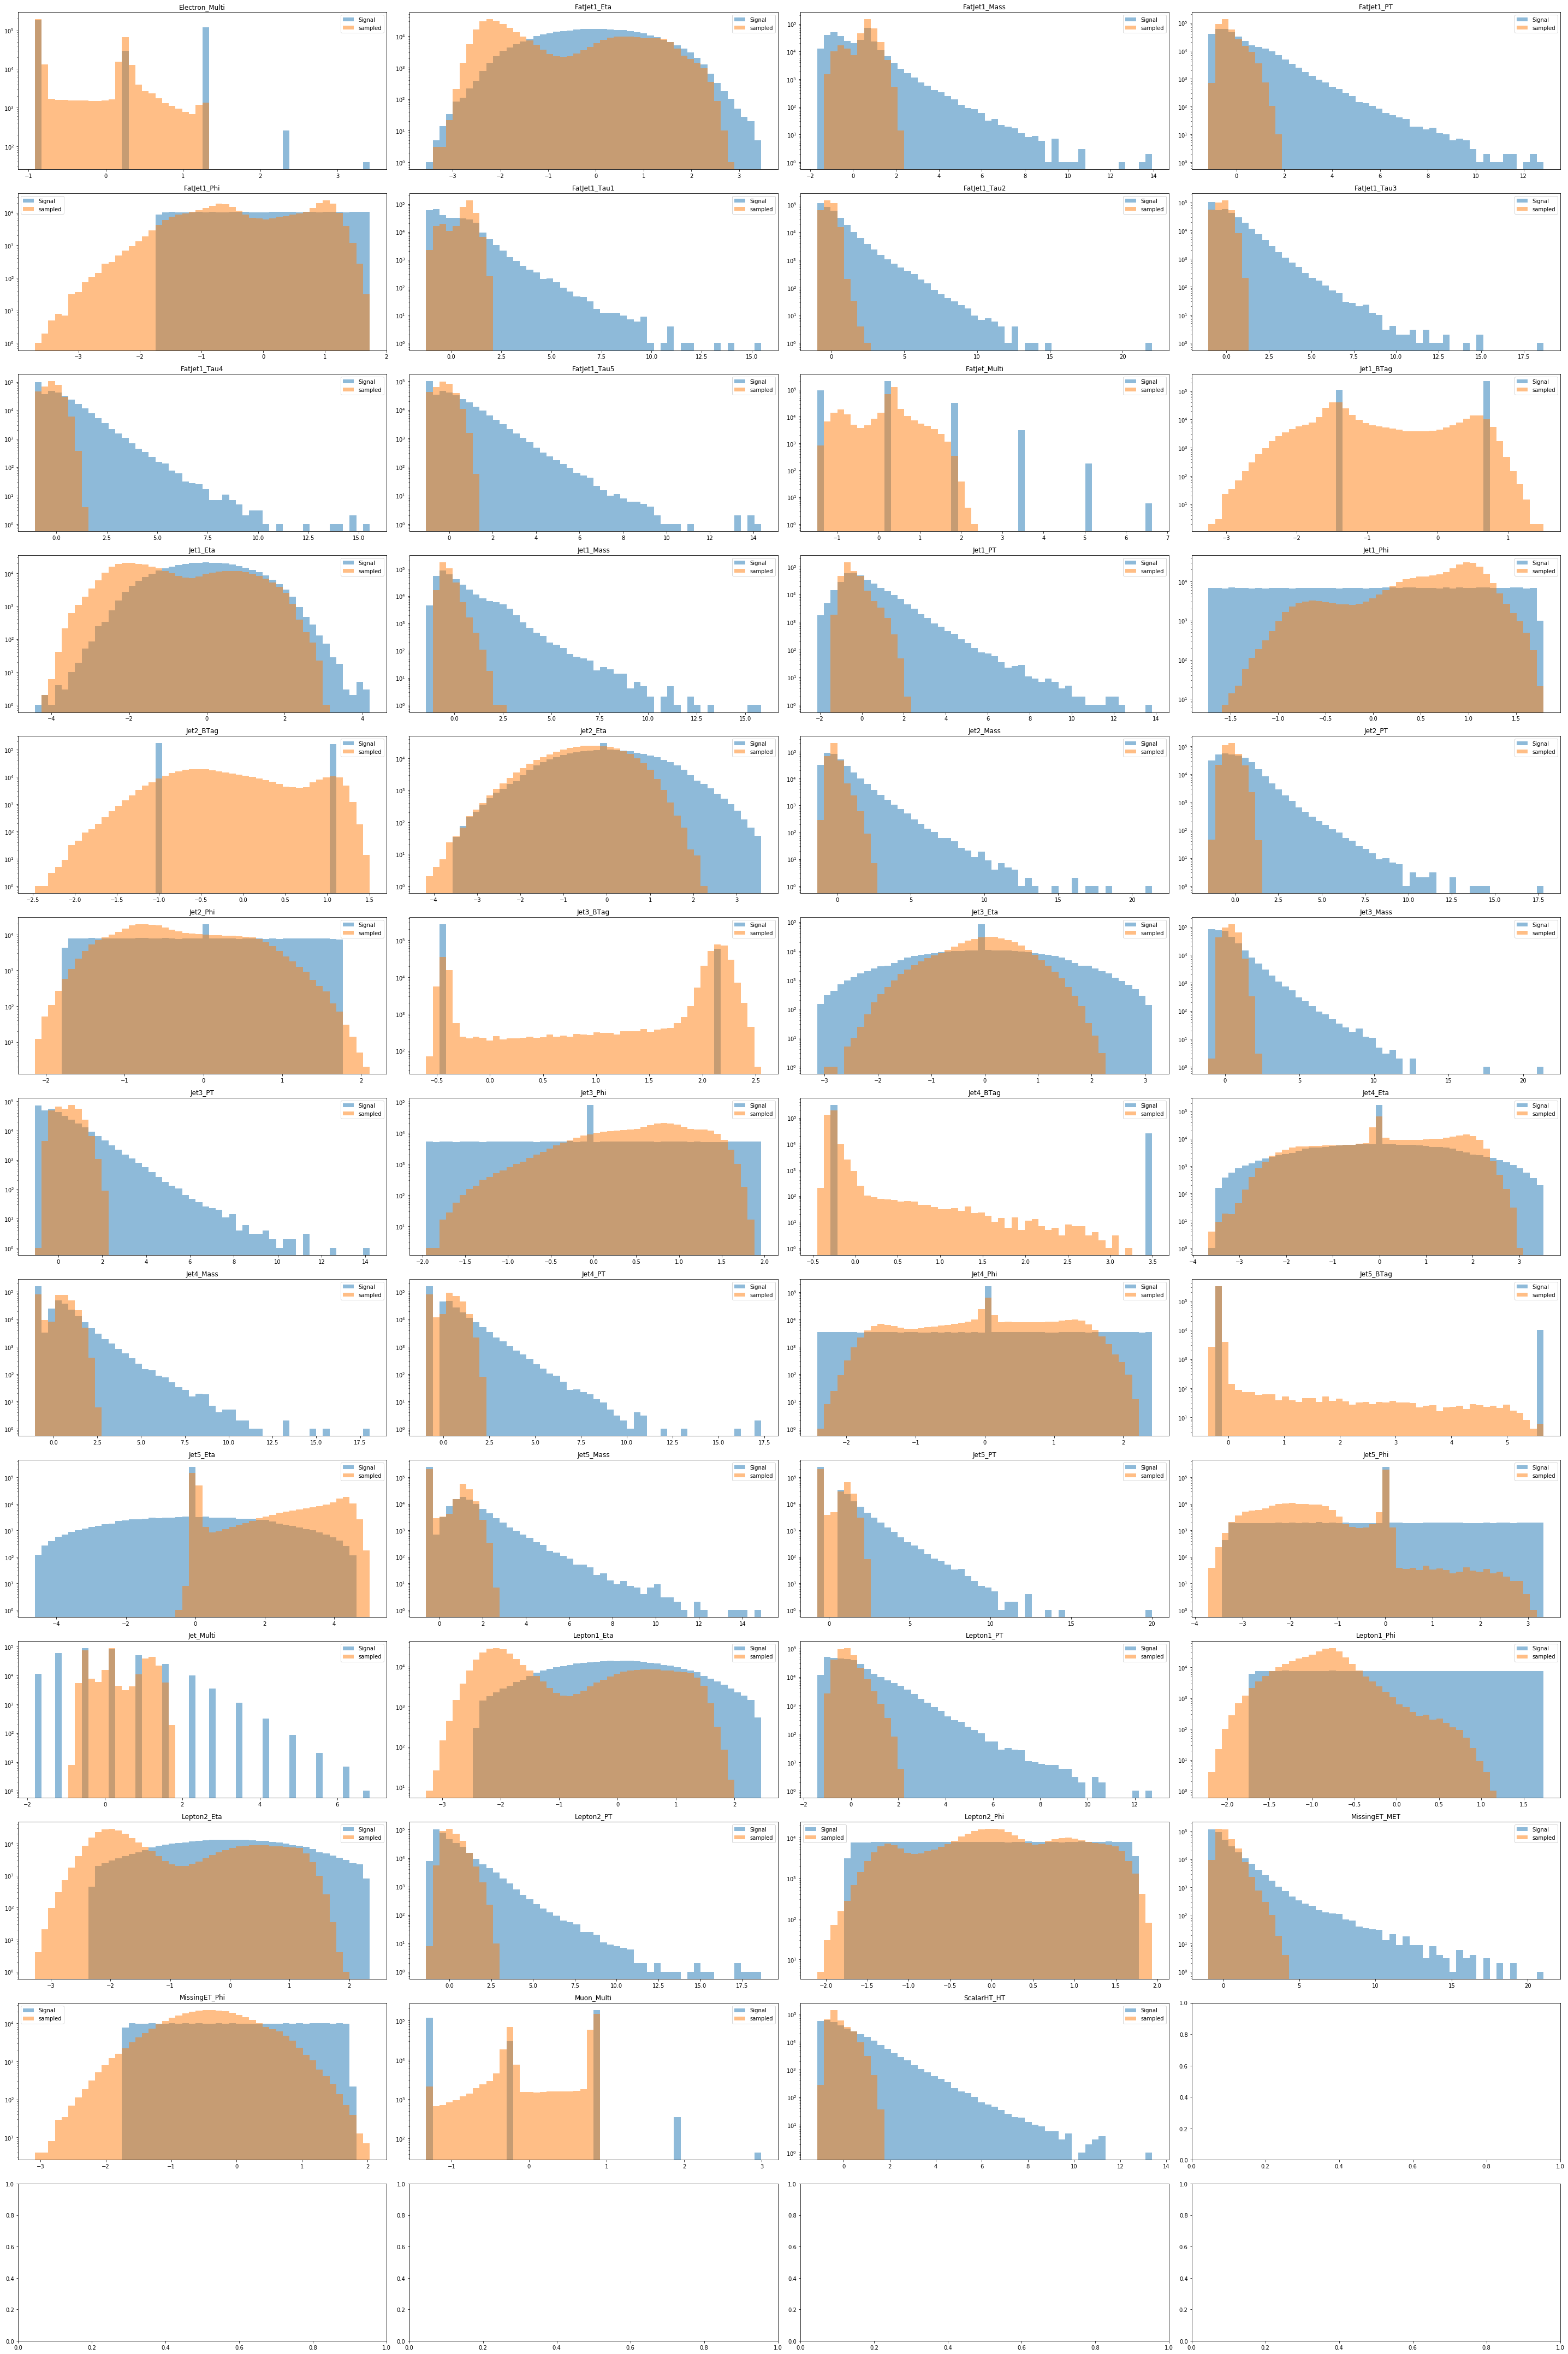

In [14]:
plot_graphs2(bkg, sample)

In [15]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

WD Score: 6.724343546741782


## Bkg Data vs Reconstruction

<ipython-input-13-fd11cf38c044>:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



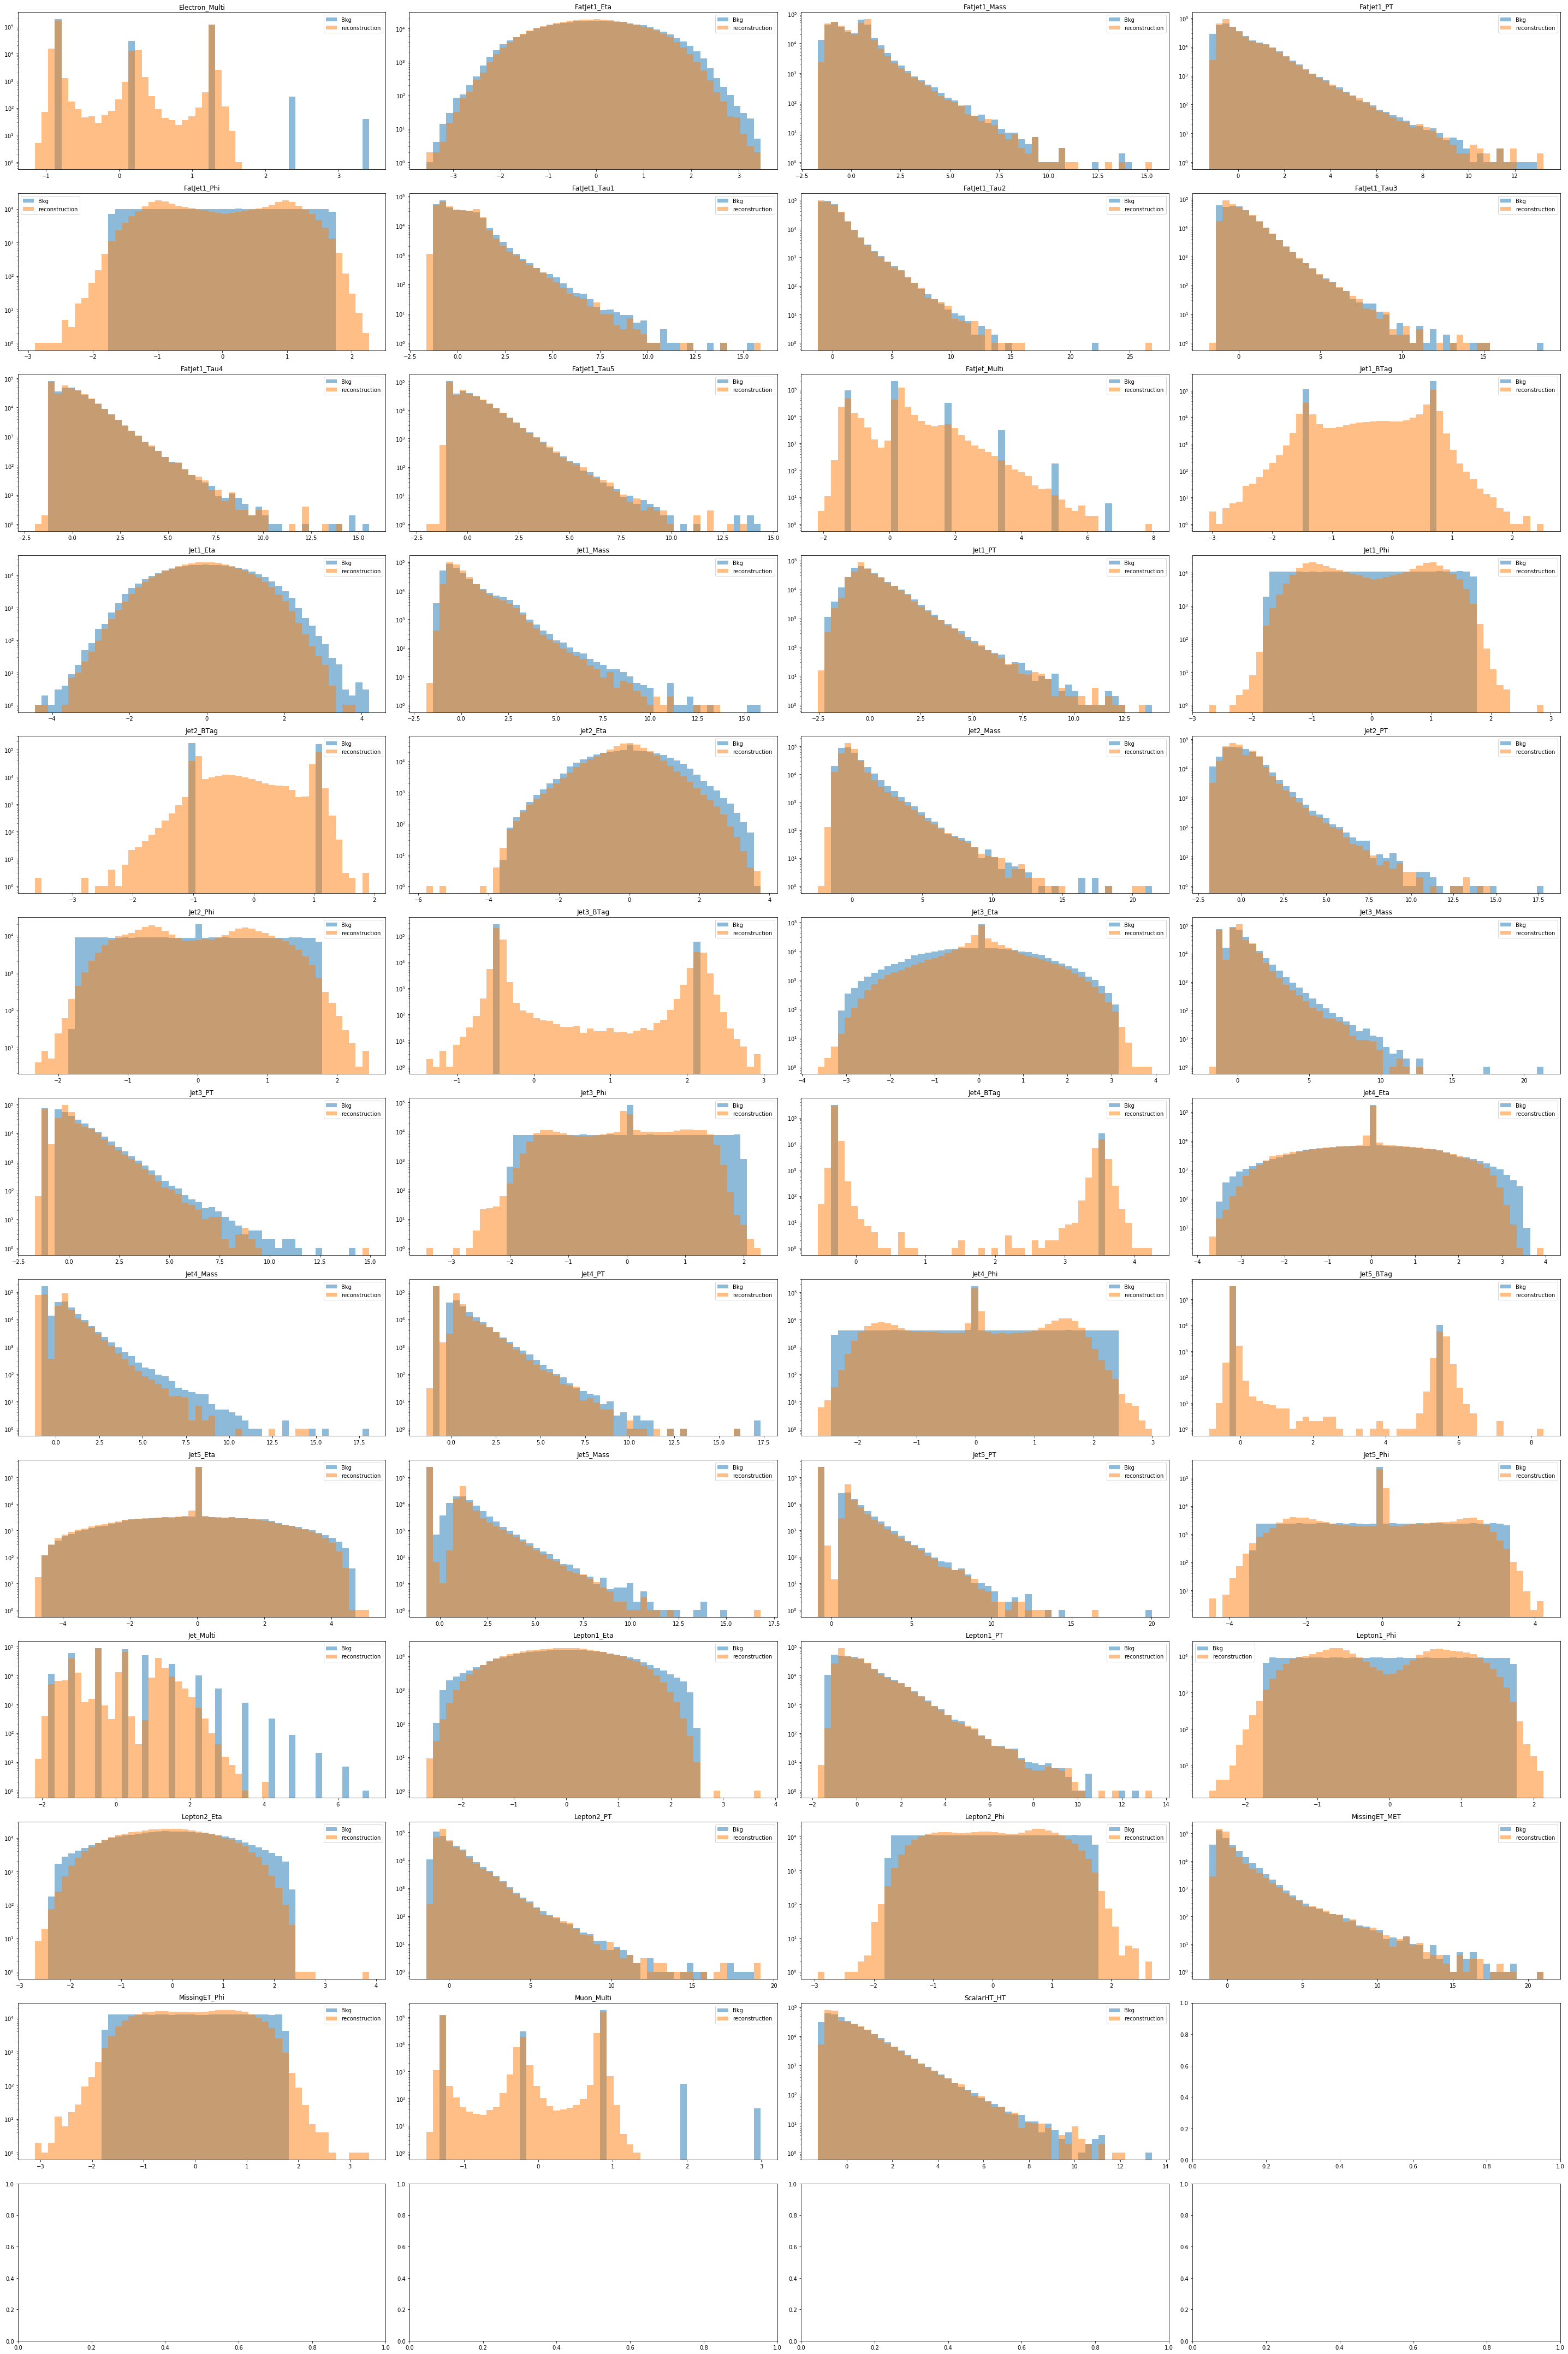

In [16]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="reconstruction")

In [17]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

R2 Score: 0.8234988415770993


## Plot error distributions and ROC Scores

Load data

In [18]:
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
signal = _dataset(category='all',variant='signal').all_data()

data = pd.concat([signal, bkg])
del signal, bkg

Plot

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,precision_score

def plot_graphs3(data, bins=50, num_cols=4):
    rocs = {}
    # Plot creation
    features = list(data['name'].unique())

    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        ## Get the relevant data
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        ## Pass input through model to get the output
        _, _, output, _ = model.test_step(sData)

        ## Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    ## Normalize the distributions
    # This way all values should be between 0 and 1

    # x transform
    min_of_dist = min(map(lambda x: min(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] - min_of_dist
    # scale
    max_of_dist = max(map(lambda x: max(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    
    ## Plot error distributions
    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    ## Plot ROC Curves
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            # Set Scores
            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 

            # Set weights
            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            # Get Curve
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            

            auc_score = roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights)
            namee = x.replace('.h5', '')

            rocs_scores[namee] = auc_score
            print(f"ROC SCORE for {namee}:", auc_score)
            #print(score.min(), score.max())
            #print(np.unique(np.rint(score)))
            print("Confusion matrix:")
            print(confusion_matrix(labels, np.rint(score)))
            print("\n")
    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()
    fig_roc.savefig(join(img_dir, dir_name+variante+"_rocs.png"), bbox_inches = 'tight')
    fig.savefig(join(img_dir, dir_name+variante+"_error_dist.png"), bbox_inches = 'tight')

    # Save rocs to pickle
    pickle.dump( rocs_scores, open( join(base_directory, "generate_tables", dir_name+"_"+variante+".p"), "wb" ) )

ROC SCORE for fcnc: 0.8290565519620825
Confusion matrix:
[[222298 111865]
 [ 13010  77068]]


ROC SCORE for hg3000_hq1400: 0.9859253174008524
Confusion matrix:
[[222298 111865]
 [     3  25549]]


ROC SCORE for hg3000_hq1200: 0.9863658147708303
Confusion matrix:
[[222298 111865]
 [     3  26551]]


ROC SCORE for wohg_hq1000: 0.9868798987830567
Confusion matrix:
[[222298 111865]
 [     3  28218]]


ROC SCORE for wohg_hq1200: 0.985998802629083
Confusion matrix:
[[222298 111865]
 [     5  26456]]


ROC SCORE for hg3000_hq1000: 0.9864215914529201
Confusion matrix:
[[222298 111865]
 [     1  28178]]


ROC SCORE for wohg_hq1400: 0.9855599246127826
Confusion matrix:
[[222298 111865]
 [     4  25153]]





<ipython-input-19-a0ea9cc86ec4>:103: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



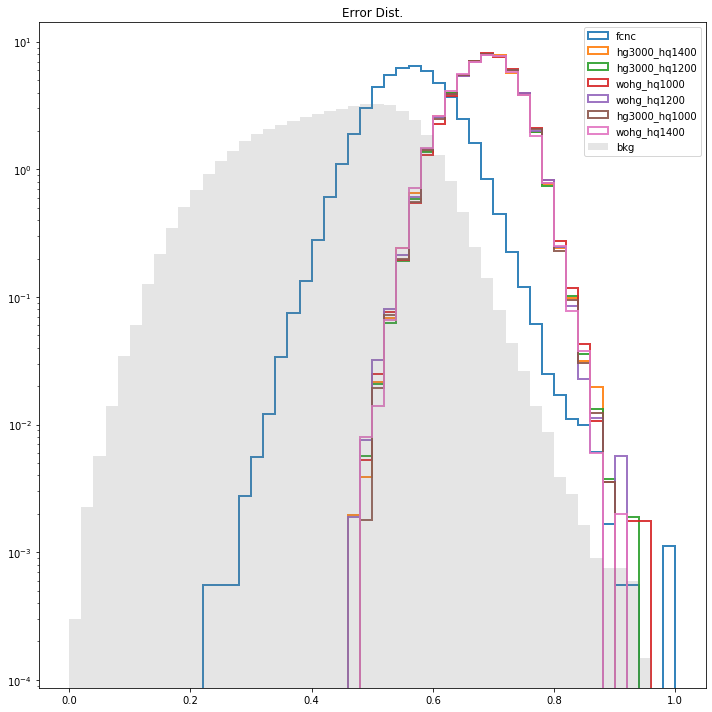

/home/acujl/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



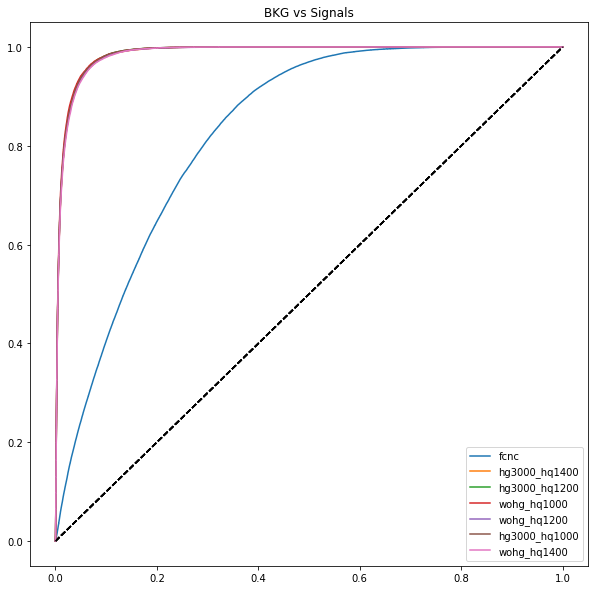

<ipython-input-19-a0ea9cc86ec4>:110: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



In [20]:
plot_graphs3(data)